## Random Forest Baseline Quickstart for NetML-Competition 2020

### * Loads datasets, plots confusion matrix, prints evaluation metrics on validation set and create submission JSON files

In [33]:
import os
import json
import argparse
import time as t
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import StackingClassifier

from utils.helper import *

In [34]:
# Define function to create submissions
def do_submit(clf, test_set, scaler, class_label_pair, filepath):
    Xtest, ids = get_submission_data(test_set)
    X_test_scaled = scaler.transform(Xtest)
    print("Predicting on {} ...".format(test_set.split('/')[-1]))
    predictions = clf.predict(X_test_scaled)
    make_submission(predictions, ids, class_label_pair, filepath)   

In [35]:
# Modify only this cell:
# Note: anno = "mid" is valid ONLY with non-vpn2016 dataset
###
dataset = "./data/non-vpn2016" # or "./data/CICIDS2017" or "./data/non-vpn2016"
anno = "mid" # or "mid" or "fine"
submit = "both" # or "test-std" or "test-challenge"
###

In [36]:
# Assign variables
training_set = dataset+"/2_training_set"
training_anno_file = dataset+"/2_training_annotations/2_training_anno_"+anno+".json.gz"
test_set = dataset+"/1_test-std_set"
challenge_set = dataset+"/0_test-challenge_set"

In [37]:
# Create folder for the results
time_ = t.strftime("%Y%m%d-%H%M%S")

save_dir = os.getcwd() + '/results/' + time_
os.makedirs(save_dir)

In [38]:
# Get training data in np.array format
Xtrain, ytrain, class_label_pair, Xtrain_ids = get_training_data(training_set, training_anno_file)

# Split validation set from training data
X_train, X_val, y_train, y_val = train_test_split(Xtrain, ytrain,
                                                test_size=0.2, 
                                                random_state=42,
                                                stratify=ytrain)


Loading training set ...
Reading 2_training_set.json.gz


In [39]:
# Get name of each class to display in confusion matrix
class_names = list(sorted(class_label_pair.keys()))

# Preprocess the data
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [40]:
# Train RF Model
print("Training the model ...")

DT = DecisionTreeClassifier(random_state = 42)
ET = ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs = -1)
RF = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs = -1, max_features="auto")


eclf = StackingClassifier(estimators=[('dtc', DT), ('rfc', RF)],final_estimator=ET ,n_jobs=-1)
eclf.fit(X_train_scaled, y_train)

Training the model ...


StackingClassifier(estimators=[('dtc', DecisionTreeClassifier(random_state=42)),
                               ('rfc',
                                RandomForestClassifier(n_jobs=-1,
                                                       random_state=42))],
                   final_estimator=ExtraTreesClassifier(n_jobs=-1,
                                                        random_state=42),
                   n_jobs=-1)

In [41]:
# Output accuracy of classifier

print("eclf")
print("Training Score: \t{:.5f}".format(eclf.score(X_train_scaled, y_train)))
print("Validation Score: \t{:.5f}".format(eclf.score(X_val_scaled, y_val)))

eclf
Training Score: 	0.48929
Validation Score: 	0.46271


F1: 			0.45164
mAP: 			0.37673
Confusion matrix is saved as ./results/20210428-014214/CM.png



(<AxesSubplot:title={'center':'Confusion matrix, without normalization\nF1:0.45164 - mAP:0.37673'}, xlabel='Predicted label', ylabel='True label'>,
 array([[   0,    0,   12,    2,    0,    0,   12,    1,    0,    0,    0,
           35,    0,    0,    0,    0,    5,    0],
        [   0,  553,   42,    0,    0,    0,   43,    0,    0,    0,    0,
          192,    0,    0,    0,    0,    2,    0],
        [   2,   70, 2334,    0,    1,    0, 1173,    0,    1,    0,    0,
         3514,    0,    0,    0,    2,    1,    9],
        [   0,    3,    2,   67,    0,    0,    6,    0,    0,    0,    0,
            6,    0,    4,    0,    0,   44,    1],
        [   1,    0,    5,    0,   47,    0,    9,    0,    0,    0,    0,
            8,    0,    0,    0,    0,    3,    0],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    1],
        [   0,   79, 1454,    4,    5,    0, 2611,    3,    0,    0,    0,
         3429, 

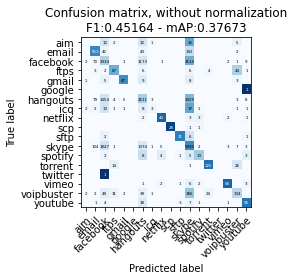

In [44]:
# Print Confusion Matrix
ypred = eclf.predict(X_val_scaled)

np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plot_confusion_matrix(directory=save_dir, y_true=y_val, y_pred=ypred, 
                        classes=class_names, 
                        normalize=False)

In [45]:
# Make submission with JSON format
if submit == "test-std" or submit == "both":
    do_submit(eclf, test_set, scaler, class_label_pair, save_dir+"/submission_test-std.json")
if submit == "test-challenge" or submit == "both":
    do_submit(eclf, challenge_set, scaler, class_label_pair, save_dir+"/submission_test-challenge.json")


Loading submission set ...
Reading 1_test-std_set.json.gz
Predicting on 1_test-std_set ...
Submission file is created as ./results/20210428-014214/submission_test-std.json

Loading submission set ...
Reading 0_test-challenge_set.json.gz
Predicting on 0_test-challenge_set ...
Submission file is created as ./results/20210428-014214/submission_test-challenge.json

